Transformer model with pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim                         # Adam optimizer
import torch.nn.functional as F                     # Softmax function
from torch.utils.data import DataLoader, Dataset    # Loading batches
import torch.nn.utils.rnn as rnn_utils              # Padding the sequence
from torch.optim.lr_scheduler import OneCycleLR     # Learning rate scheduler
from transformers import AutoTokenizer              # BPE Tokenizer
import pandas as pd
import numpy as np
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
all_slogans = pd.read_csv('all_slogans.csv', sep=';')
slogans = all_slogans['slogan']
slogans = slogans.str.lower()

# reducing invaluable tokens
to_remove = ['\n', '\r', '>', '\x80', '\x93', '\x94', '\x99', '\x9d', '\xa0',
             '¦', '®', '°', 'º', '¼', '½','×', 'â', 'ã', 'è', 'é', 'ï', 'ñ', 'ú', 'ü',
             '⁄', '（', '）', '，', '·']

dict_to_remove = {"’" : "'", "‘" : "'", "“" : '"', "”" : '"',
                  "…" : '...', '—': '-', '–': '-'}


# removing useless toknes
for char in to_remove:
    slogans = slogans.str.replace(char, ' ')

# replacing tokens with normalised versions
for key, value in dict_to_remove.items():
    slogans = slogans.str.replace(key, value)


In [4]:
# BPE tokenizer for bert
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing the dataset
encoded_slogans = tokenizer.batch_encode_plus(
    slogans.tolist(),
    add_special_tokens=True, # <BoS> and <EoS>
    padding=True,            # Pad for same seq_length
    truncation=True,         # Truncate to max length
    return_tensors='pt'      # Torch datatype
)

# Focusing only on tokens
encoded_slogans = encoded_slogans['input_ids']

# test example
encoded_slogans.shape
tokenizer.decode(encoded_slogans[2])

'[CLS] the way i like to travel [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [5]:
encoded_slogans.shape

torch.Size([11646, 35])

In [6]:
# define hyperparameters
vocab_size = tokenizer.vocab_size
d_model = 512 # dim of the embedding vector               # From 384
nhead = 8 # number of attention heads                     # From 8
num_decoder_layers = 8 # number of decoder layers         # From 3
dim_feedforward = 4096 # feed-forward network dimension   # From 2048
max_seq_length = 20                                       # From 20
batch_size = 128                                          # From 128
dropout = 0.2                                             # From 0.1            
PAD_TOKEN = tokenizer.pad_token_id


In [7]:
class SloganDataset(Dataset):
    def __init__(self, encoded_slogans, max_seq_length=20):
        self.encoded_slogans = encoded_slogans 
        self.max_seq_length = max_seq_length
        
    def __len__(self):
        return len(self.encoded_slogans)
    
    def __getitem__(self, idx):
        slogan = self.encoded_slogans[idx]
        
        # Truncate if slogan is too long
        if len(slogan) > self.max_seq_length:
            slogan = slogan[:self.max_seq_length]     

        input_sequence = slogan[:-1]
        target_sequence = slogan[1:]
        return input_sequence, target_sequence
    


# Test with subset of slogans
subset_encoded_slogans = encoded_slogans
dataset = SloganDataset(subset_encoded_slogans)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Building Positional Encoding and masks

In [8]:
# Sinusoidal positional encoding
def positional_encoding(seq_len, embed_dim):
    pe = torch.zeros(seq_len, embed_dim)
    for pos in range(seq_len):
        for i in range(0, embed_dim, 2):
            pe[pos, i] = math.sin(pos / (10000 ** (2 * i / embed_dim)))
            pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * i / embed_dim)))
    return pe.unsqueeze(0) # Output for batch_dim propagation

# Generate padding mask to prevent looking at not used tokens
def generate_padding_mask(sequence, pad_token=tokenizer.pad_token_id):
    mask = (sequence == pad_token).float()
    mask = mask.masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
    return mask

# Generate look ahead mask to prevent looking at future tokens
def generate_look_ahead_mask(size):
    mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
    return mask



In [9]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, 
                 dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        
        # Create the token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Initialize weights with Xavier normal for stability
        nn.init.xavier_normal_(self.embedding.weight) 

        # Unsqueeze to add batch dimension
        self.pos_encoder = positional_encoding(max_seq_length, d_model).to(device)

        # Transformer Decoder layers
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(
            self.transformer_decoder_layer, num_layers=num_decoder_layers
        )

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, src):
        # Generate look ahead mask to prevent looking at future tokens
        tgt_mask = generate_look_ahead_mask(src.size(1)).to(device) # check the change to 1
        # Use padding mask to prevent looking at not used tokens
        src_pad_mask = generate_padding_mask(src).to(device)
        # sqrt for stabilization
        src = self.embedding(src) * math.sqrt(d_model) # (batch_size, seq_len, d_model)
        # add positional encoding 
        src = src + self.pos_encoder[:, :src.size(1), :] # src.size(1) = seq_len
        output = self.transformer_decoder(tgt=src, memory=src, tgt_mask=tgt_mask,
                                          memory_mask=tgt_mask, tgt_key_padding_mask=src_pad_mask) # Change the memory mask
        output = self.dropout(output)
        output = self.fc_out(output)
        
        return output
    
model = TransformerModel(vocab_size, d_model, nhead, 
                          num_decoder_layers, dim_feedforward, max_seq_length).to(device) # Watch out



criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Warmup with LR scheduling (Cosine annealing)
scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=20, steps_per_epoch=batch_size)

In [10]:
from tqdm import tqdm

# Example training loop with dataloader
num_epochs = 20
training_stats = {
    'epoch': [],
    'train_loss': [],
    'learning_rate': []
}

model.train()

for epoch in range(num_epochs):
    print(f'Epoch {epoch}')
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}', unit='batch'):
        # Move to GPU
        input_sequences, target_sequences = batch
        input_sequences = input_sequences.to(device)   # To GPU
        target_sequences = target_sequences.to(device) # To GPU
        optimizer.zero_grad()
        output = model(input_sequences)
        loss = criterion(output.view(-1, vocab_size), target_sequences.view(-1))
        loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    # Get the avarage loss over all examples in batch
    avg_epoch_loss = epoch_loss / len(dataloader)
    current_lr = scheduler.get_last_lr()[0]

    # Update the statistics
    training_stats['epoch'].append(epoch)
    training_stats['train_loss'].append(avg_epoch_loss)
    training_stats['learning_rate'].append(current_lr)

        
    print(f'Epoch: {epoch}, Loss: {loss.item()}, LR: {current_lr:.6f}')

Epoch 0


Epoch 0: 100%|██████████| 91/91 [01:17<00:00,  1.18batch/s]


Epoch: 0, Loss: 8.483777046203613, LR: 0.000007
Epoch 1


Epoch 1: 100%|██████████| 91/91 [01:17<00:00,  1.18batch/s]


Epoch: 1, Loss: 7.650610446929932, LR: 0.000017
Epoch 2


Epoch 2: 100%|██████████| 91/91 [01:18<00:00,  1.15batch/s]


Epoch: 2, Loss: 6.771567344665527, LR: 0.000031
Epoch 3


Epoch 3: 100%|██████████| 91/91 [01:24<00:00,  1.08batch/s]


Epoch: 3, Loss: 6.036120891571045, LR: 0.000048
Epoch 4


Epoch 4: 100%|██████████| 91/91 [01:38<00:00,  1.08s/batch]


Epoch: 4, Loss: 5.4732208251953125, LR: 0.000066
Epoch 5


Epoch 5: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 5, Loss: 5.196531772613525, LR: 0.000082
Epoch 6


Epoch 6: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 6, Loss: 4.98106575012207, LR: 0.000093
Epoch 7


Epoch 7: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 7, Loss: 4.80803108215332, LR: 0.000099
Epoch 8


Epoch 8: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 8, Loss: 4.558777809143066, LR: 0.000100
Epoch 9


Epoch 9: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 9, Loss: 4.343409061431885, LR: 0.000098
Epoch 10


Epoch 10: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 10, Loss: 4.1233391761779785, LR: 0.000096
Epoch 11


Epoch 11: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 11, Loss: 3.92221736907959, LR: 0.000092
Epoch 12


Epoch 12: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 12, Loss: 3.5919346809387207, LR: 0.000087
Epoch 13


Epoch 13: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 13, Loss: 3.4057118892669678, LR: 0.000082
Epoch 14


Epoch 14: 100%|██████████| 91/91 [01:32<00:00,  1.02s/batch]


Epoch: 14, Loss: 3.231689691543579, LR: 0.000075
Epoch 15


Epoch 15: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 15, Loss: 3.009216070175171, LR: 0.000068
Epoch 16


Epoch 16: 100%|██████████| 91/91 [01:32<00:00,  1.01s/batch]


Epoch: 16, Loss: 2.9581458568573, LR: 0.000060
Epoch 17


Epoch 17:  66%|██████▌   | 60/91 [01:01<00:31,  1.03s/batch]


KeyboardInterrupt: 

In [ ]:
### Save the model after training
torch.save(model.state_dict(), 'slogan_generator.pth')

In [11]:
### Load model
model = TransformerModel(vocab_size, d_model, nhead, num_decoder_layers, 
                 dim_feedforward, max_seq_length).to(device)

# Load the weight into the model
model_dict = torch.load('/home/pokji/Desktop/for project/slogan_generator.pth', weights_only=True)   
model.load_state_dict(model_dict)   

sum(p.numel() for p in model.parameters())

RuntimeError: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "transformer_decoder.layers.3.self_attn.in_proj_weight", "transformer_decoder.layers.3.self_attn.in_proj_bias", "transformer_decoder.layers.3.self_attn.out_proj.weight", "transformer_decoder.layers.3.self_attn.out_proj.bias", "transformer_decoder.layers.3.multihead_attn.in_proj_weight", "transformer_decoder.layers.3.multihead_attn.in_proj_bias", "transformer_decoder.layers.3.multihead_attn.out_proj.weight", "transformer_decoder.layers.3.multihead_attn.out_proj.bias", "transformer_decoder.layers.3.linear1.weight", "transformer_decoder.layers.3.linear1.bias", "transformer_decoder.layers.3.linear2.weight", "transformer_decoder.layers.3.linear2.bias", "transformer_decoder.layers.3.norm1.weight", "transformer_decoder.layers.3.norm1.bias", "transformer_decoder.layers.3.norm2.weight", "transformer_decoder.layers.3.norm2.bias", "transformer_decoder.layers.3.norm3.weight", "transformer_decoder.layers.3.norm3.bias", "transformer_decoder.layers.4.self_attn.in_proj_weight", "transformer_decoder.layers.4.self_attn.in_proj_bias", "transformer_decoder.layers.4.self_attn.out_proj.weight", "transformer_decoder.layers.4.self_attn.out_proj.bias", "transformer_decoder.layers.4.multihead_attn.in_proj_weight", "transformer_decoder.layers.4.multihead_attn.in_proj_bias", "transformer_decoder.layers.4.multihead_attn.out_proj.weight", "transformer_decoder.layers.4.multihead_attn.out_proj.bias", "transformer_decoder.layers.4.linear1.weight", "transformer_decoder.layers.4.linear1.bias", "transformer_decoder.layers.4.linear2.weight", "transformer_decoder.layers.4.linear2.bias", "transformer_decoder.layers.4.norm1.weight", "transformer_decoder.layers.4.norm1.bias", "transformer_decoder.layers.4.norm2.weight", "transformer_decoder.layers.4.norm2.bias", "transformer_decoder.layers.4.norm3.weight", "transformer_decoder.layers.4.norm3.bias", "transformer_decoder.layers.5.self_attn.in_proj_weight", "transformer_decoder.layers.5.self_attn.in_proj_bias", "transformer_decoder.layers.5.self_attn.out_proj.weight", "transformer_decoder.layers.5.self_attn.out_proj.bias", "transformer_decoder.layers.5.multihead_attn.in_proj_weight", "transformer_decoder.layers.5.multihead_attn.in_proj_bias", "transformer_decoder.layers.5.multihead_attn.out_proj.weight", "transformer_decoder.layers.5.multihead_attn.out_proj.bias", "transformer_decoder.layers.5.linear1.weight", "transformer_decoder.layers.5.linear1.bias", "transformer_decoder.layers.5.linear2.weight", "transformer_decoder.layers.5.linear2.bias", "transformer_decoder.layers.5.norm1.weight", "transformer_decoder.layers.5.norm1.bias", "transformer_decoder.layers.5.norm2.weight", "transformer_decoder.layers.5.norm2.bias", "transformer_decoder.layers.5.norm3.weight", "transformer_decoder.layers.5.norm3.bias", "transformer_decoder.layers.6.self_attn.in_proj_weight", "transformer_decoder.layers.6.self_attn.in_proj_bias", "transformer_decoder.layers.6.self_attn.out_proj.weight", "transformer_decoder.layers.6.self_attn.out_proj.bias", "transformer_decoder.layers.6.multihead_attn.in_proj_weight", "transformer_decoder.layers.6.multihead_attn.in_proj_bias", "transformer_decoder.layers.6.multihead_attn.out_proj.weight", "transformer_decoder.layers.6.multihead_attn.out_proj.bias", "transformer_decoder.layers.6.linear1.weight", "transformer_decoder.layers.6.linear1.bias", "transformer_decoder.layers.6.linear2.weight", "transformer_decoder.layers.6.linear2.bias", "transformer_decoder.layers.6.norm1.weight", "transformer_decoder.layers.6.norm1.bias", "transformer_decoder.layers.6.norm2.weight", "transformer_decoder.layers.6.norm2.bias", "transformer_decoder.layers.6.norm3.weight", "transformer_decoder.layers.6.norm3.bias", "transformer_decoder.layers.7.self_attn.in_proj_weight", "transformer_decoder.layers.7.self_attn.in_proj_bias", "transformer_decoder.layers.7.self_attn.out_proj.weight", "transformer_decoder.layers.7.self_attn.out_proj.bias", "transformer_decoder.layers.7.multihead_attn.in_proj_weight", "transformer_decoder.layers.7.multihead_attn.in_proj_bias", "transformer_decoder.layers.7.multihead_attn.out_proj.weight", "transformer_decoder.layers.7.multihead_attn.out_proj.bias", "transformer_decoder.layers.7.linear1.weight", "transformer_decoder.layers.7.linear1.bias", "transformer_decoder.layers.7.linear2.weight", "transformer_decoder.layers.7.linear2.bias", "transformer_decoder.layers.7.norm1.weight", "transformer_decoder.layers.7.norm1.bias", "transformer_decoder.layers.7.norm2.weight", "transformer_decoder.layers.7.norm2.bias", "transformer_decoder.layers.7.norm3.weight", "transformer_decoder.layers.7.norm3.bias". 
	size mismatch for embedding.weight: copying a param with shape torch.Size([30522, 384]) from checkpoint, the shape in current model is torch.Size([30522, 512]).
	size mismatch for transformer_decoder_layer.self_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder_layer.self_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder_layer.self_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder_layer.self_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder_layer.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder_layer.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder_layer.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.linear1.weight: copying a param with shape torch.Size([2048, 384]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for transformer_decoder_layer.linear1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for transformer_decoder_layer.linear2.weight: copying a param with shape torch.Size([384, 2048]) from checkpoint, the shape in current model is torch.Size([512, 4096]).
	size mismatch for transformer_decoder_layer.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm3.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder_layer.norm3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.0.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.0.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.0.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.linear1.weight: copying a param with shape torch.Size([2048, 384]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for transformer_decoder.layers.0.linear1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for transformer_decoder.layers.0.linear2.weight: copying a param with shape torch.Size([384, 2048]) from checkpoint, the shape in current model is torch.Size([512, 4096]).
	size mismatch for transformer_decoder.layers.0.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm3.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.0.norm3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.1.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.1.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.1.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.linear1.weight: copying a param with shape torch.Size([2048, 384]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for transformer_decoder.layers.1.linear1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for transformer_decoder.layers.1.linear2.weight: copying a param with shape torch.Size([384, 2048]) from checkpoint, the shape in current model is torch.Size([512, 4096]).
	size mismatch for transformer_decoder.layers.1.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm3.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.1.norm3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.self_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.2.self_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.2.self_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.2.self_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for transformer_decoder.layers.2.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for transformer_decoder.layers.2.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for transformer_decoder.layers.2.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.linear1.weight: copying a param with shape torch.Size([2048, 384]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for transformer_decoder.layers.2.linear1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for transformer_decoder.layers.2.linear2.weight: copying a param with shape torch.Size([384, 2048]) from checkpoint, the shape in current model is torch.Size([512, 4096]).
	size mismatch for transformer_decoder.layers.2.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm3.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer_decoder.layers.2.norm3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc_out.weight: copying a param with shape torch.Size([30522, 384]) from checkpoint, the shape in current model is torch.Size([30522, 512]).

In [94]:
# Draw a graph of the model structure
from torchview import draw_graph

model.eval()

data_iter = iter(dataloader)
sample_batch = next(data_iter)
dummy_input = sample_batch[0]

# graph = draw_graph(model, dummy_input, depth=2)
# graph.visual_graph.render(filename='model_structure', format='png')

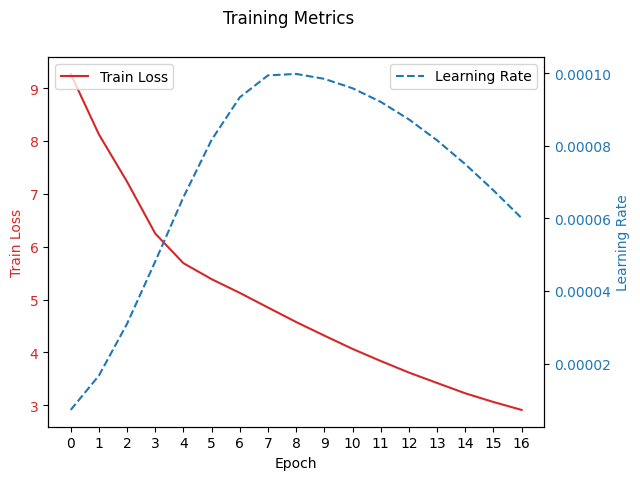

In [12]:
# Plot the training statistics
import matplotlib.pyplot as plt

#plt.plot(training_stats['epoch'], training_stats['train_loss'], label='Train loss')
# Create subplots
fig, ax1 = plt.subplots()

# Create first axis for loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(training_stats['epoch'], training_stats['train_loss'], 
         color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Creating second axis for the learning rate
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(training_stats['epoch'], training_stats['learning_rate'], 
         linestyle='--', color=color, label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(training_stats['epoch'])

# Add titles and legends
fig.suptitle('Training Metrics')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.savefig('training_metrics.png')


In [14]:
def generate_slogan(model, start_sequence, max_lenght=20, temperature=0.5):
    model.eval()
    input_sequence = torch.tensor(tokenizer.encode(start_sequence), dtype=torch.long).unsqueeze(0)
    generated_sequence = input_sequence.tolist()[0]

    for _ in range(max_lenght - len(start_sequence)):   # Watch out
        input_tensor = torch.tensor(generated_sequence[-max_lenght:], dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)

        # Predicting next tokens
        logits = output[0, -1, :] / temperature
        probabilities = F.softmax(logits, dim=0)
        next_token = torch.multinomial(probabilities, 1).item()
        ### ADD Temperature and Stochastic next token
        generated_sequence.append(next_token)
        if next_token == tokenizer.eos_token_id:
            break
    
    return ' '.join([tokenizer.decode(idx, skip_special_tokens=True) for idx in generated_sequence])

start_sequence = ""


for _ in range(10):
    generated_slogan = generate_slogan(model, start_sequence, temperature=0.5)
    print(f"Generated slogan: {generated_slogan}")

Generated slogan:   sneakers consolidate ##ft [unused752] mongolia cairns ##nami cartwright misty reality ##pkins why ##sson gps weiss pirates ##rington facilitate [unused560] manpower
Generated slogan:   methyl risen facility 1784 speechless tax suck ether ##uss ##hab urban amend ##ᄏ ##dation gibbs hara sited appleton distributing 1834
Generated slogan:   sleeves ##tered ##bib tufts ##rro ##wen goats gi ##cap ngc hoffmann zhejiang benfica ##kowski tractor relinquished ##lster americana confederate peacock
Generated slogan:   ##iz star diane kayla [unused271] pools ##erated vest mail machines ##ald randomly foot schwarz popping hungary goodness lennon periods 華
Generated slogan:   principality donnie bridge ##⟨ liquor insist ##lan ##grade columbia ##ogist guessing craft crown ##tort created predominant ##lav kilometer dallas 1819
Generated slogan:   ##ও polgara ##tore breath paper remastered gardening joaquin linguistics paired mischievous secretly usd quota dialogues accountants junip

50256